# Experiment 1: Stable Confounder

In this experiment, we use a simplified causal graph consisting of three nodes: immune state, sex, and AIRR, to show if the distribution of a confounder is stable in thestudy cohort, and source and target populations, it does not influence the prediction task.

Immune state is a binary variable and can have values `True` or `False` to indicate if an individual is diseased or healthy. Confounder (sex) also in this setting has two values. AIRR is a set of sequences simulated based on the values of the immune state and the confounder for the given individual.

Steps:

1. Simulate training and test dataset from a causal graph to include: confounder (sex, implemented by creating repertoires with different OLGA models), immune state (implemented by implanting a signal in the repertoire)

2. Train an ML model (here: logistic regression on repertoires represented by the k-mer frequencies) on the train set and assess its performance on the test set in the presence of confounder with stable distribution across train and test.

Software used: 

- DagSim for simulation of the causal graph; 
- immuneML v2.1 for implanting signal in AIRRs and for training and assessing machine learning classifiers; 
- OLGA for simulation of naive AIRRs

## Step 1: AIRR simulation from a causal graph

In [1]:
import os
import yaml
import dagsim.baseDS as ds
import numpy as np
from pathlib import Path
from util.repertoire_util import make_olga_repertoire, load_iml_repertoire, make_AIRR_dataset, make_dataset
from util.implanting import make_immune_signal, make_repertoire_without_signal, make_repertoire_with_signal
from immuneML.util.PathBuilder import PathBuilder
from immuneML.simulation.implants.Signal import Signal

In [2]:
# remove results from the previous run

import shutil

if Path("./experiment1/").is_dir():
    shutil.rmtree("./experiment1/")

In [3]:
result_path = PathBuilder.build("./experiment1/data/")

train_example_count = 200
test_example_count = 50

# immune state: two binomial distributions depending on the confounder value with probability of success p
immune_state_p_conf0 = 0.3 # for confounder = 0
immune_state_p_conf1 = 0.5 # for confounder = 1

# confounder: binomial distribution with probability of success p
confounder_p = 0.5

# other parameters
repertoire_implanting_rate = 0.01 # percentage of repertoire sequences to include immune state signal
sequence_count = 2000 # number of sequences in one repertoire

In [4]:
# define functions to create immune state, confounder, and AIRR

def get_immune_state(confounder: bool, p_conf0: float, p_conf1: float) -> bool:
    return np.random.binomial(n=1, p=p_conf1) if confounder else np.random.binomial(n=1, p=p_conf0)
    
def get_confounder(p) -> bool:
    return "C1" if np.random.binomial(n=1, p=p) > 0.5 else "C2"

def get_repertoire(immune_state: bool, confounder: str, confounder_name: str, path: Path, sequence_count: int, signal: Signal, seed: int, repertoire_implanting_rate: float) -> str:
        
    PathBuilder.build(path)    

    # make olga repertoire by using one of two Olga models based on confounder value
    naive_repertoire = make_olga_repertoire(confounder=confounder, confounder_name=confounder_name, path=path, sequence_count=sequence_count, seed=seed)
    
    # implant a signal in the repertoire based on the immune state
    if immune_state:
        repertoire = make_repertoire_with_signal(repertoire=naive_repertoire, signal=signal, result_path=path / "immuneML_with_signal/", repertoire_implanting_rate=repertoire_implanting_rate)
    else:
        repertoire = make_repertoire_without_signal(repertoire=naive_repertoire, signal_name=signal.id, result_path=path / "immuneML_with_signal/")

    return repertoire.data_filename
    

In [5]:
# define the immune signal that will represent the immune state

signal = make_immune_signal() # motifs "ADR" and "ATS" with maximum of 1 Hamming distance as immune state signal

# define nodes of the causal graph

index_node = ds.Generic(name="index", function=np.arange, size_field="stop")

confounder_node = ds.Generic(name="sex", function=get_confounder, arguments={"p": confounder_p})

immune_state_node = ds.Generic(name="immune_state", function=get_immune_state, 
                               arguments={"confounder": confounder_node, "p_conf0": immune_state_p_conf0,
                                         "p_conf1": immune_state_p_conf1})

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire, 
                             arguments={"immune_state": immune_state_node, "confounder": confounder_node, "confounder_name": confounder_node.name,
                                        "path": result_path / "train", "sequence_count": sequence_count, "signal": signal, 
                                        "seed": index_node, 'repertoire_implanting_rate': repertoire_implanting_rate})


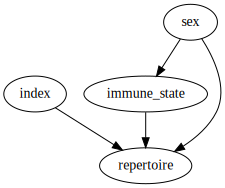

In [6]:
# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_1", list_nodes=[index_node, confounder_node, immune_state_node, repertoire_node])
graph.draw()

In [7]:
# simulate a dataset using the graph

study_cohort_data = graph.simulate(num_samples=train_example_count, csv_name=str(result_path / "train/study_cohort"))


In [8]:
# make an AIRR dataset from the generated repertoires to be used for training

repertoires = [load_iml_repertoire(filepath=filepath) for filepath in study_cohort_data["repertoire"]]

train_dataset = make_dataset(repertoires=repertoires, path=result_path / 'train', dataset_name="experiment1_train", 
                             signal_names=[signal.id, confounder_node.name])

In [9]:
# make a test dataset

repertoire_node.additional_parameters['path'] = result_path / 'test' # update result_path: to be removed with DagSim update

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(result_path / "test/test_cohort"))

test_repertoires = [load_iml_repertoire(filepath=filepath) for filepath in test_data["repertoire"]]

test_dataset = make_dataset(repertoires=test_repertoires, path=result_path / 'test', 
                            dataset_name="experiment1_test", signal_names=[signal.id, confounder_node.name])


In [10]:
# merge datasets (but the distinction between train and test will be kept in the ML analysis part)

dataset = make_AIRR_dataset(train_dataset, test_dataset, result_path / 'full_dataset')

## Step 2: train an ML model and assess performance

In [11]:
specs = {
    "definitions": {
        "datasets": {
            "dataset1": {
                "format": 'AIRR',
                "params": {
                    "path": str(result_path / 'full_dataset'),
                    "metadata_file": str(result_path / 'full_dataset/metadata.csv')
                }
            }
        },
        "encodings": {
            "kmer_frequency": {
                "KmerFrequency": {"k": 3}
            }
        },
        "ml_methods": {
            "logistic_regression": {
                "LogisticRegression": {
                    "penalty": "l1",
                    "C": [0.01, 0.1, 1, 10, 100],
                    "max_iter": 1500
                },
                "model_selection_cv": True,
                "model_selection_n_folds": 5
            }
        },
        "reports": {
            "training_performance": { # report that will allow for comparison of train/test performance
                "TrainingPerformance": {
                    "metrics": ["log_loss", "balanced_accuracy", "auc"]
                }
            },
            "motif_recovery": { # to check how much coefficients overlap with the immune state signal that was implanted
                "MotifSeedRecovery": {
                    "implanted_motifs_per_label": {
                        "immune_state": {
                            "seeds": ["ADR", "ATS"],
                            "hamming_distance": True,
                            "gap_sizes": [0] # no gaps
                        }
                    }
                }
            },
            "coefficients": {
                "Coefficients": { # show top 25 logistic regression coefficients and what k-mers they correspond to
                    "coefs_to_plot": ['n_largest'],
                    "n_largest": [25]
                }
            },
            "feature_comparison": {
                "FeatureComparison": {
                    "comparison_label": "immune_state",
                    "color_grouping_label": "sex",
                    "show_error_bar": False,
                    "keep_fraction": 0.1
                }
            }
        }
    },
    "instructions": {
        'train_ml': {
            "type": "TrainMLModel",
            "assessment": { # ensure here that train and test dataset are fixed, as per simulation
                "split_strategy": "manual",
                "split_count": 1,
                "manual_config": {
                    "train_metadata_path": str(result_path / "train/experiment1_train_metadata.csv"),
                    "test_metadata_path": str(result_path / "test/experiment1_test_metadata.csv")
                },
                "reports": {
                    "models": ["training_performance", "coefficients", "motif_recovery"],
                    "encoding": ["feature_comparison"]
                }
            },
            "selection": {
                "split_strategy": "random",
                "train_percentage": 0.7,
                "split_count": 1,
                "reports": {
                    "models": ["training_performance", "coefficients", "motif_recovery"],
                    "encoding": ["feature_comparison"]
                }
            },
            "settings": [
                {"encoding": "kmer_frequency", "ml_method": "logistic_regression"}
            ],
            "dataset": "dataset1",
            "refit_optimal_model": False,
            "labels": ["immune_state"],
            "optimization_metric": "log_loss",
            "metrics": ['balanced_accuracy', 'auc']
        }
    }
}

ml_result_path = PathBuilder.build("./experiment1/ml_result/")
specification_path = ml_result_path / "specs.yaml"

with open(specification_path, "w") as file:
    yaml.dump(specs, file)

In [12]:
# run immuneML with the specs file

output_path = ml_result_path / "result/"

os.system(f"immune-ml {specification_path} {output_path}")

print("The results are located under ./experiment1/")

2021-11-10 12:08:56.030686: Setting temporary cache path to experiment1/ml_result/result/cache
2021-11-10 12:08:56.030747: ImmuneML: parsing the specification...

2021-11-10 12:09:36.284294: Full specification is available at experiment1/ml_result/result/full_specs.yaml.

2021-11-10 12:09:36.284405: ImmuneML: starting the analysis...

2021-11-10 12:09:36.284453: Instruction 1/1 has started.
2021-11-10 12:09:36.348641: Training ML model: running outer CV loop: started split 1/1.

2021-11-10 12:09:36.394965: Hyperparameter optimization: running the inner loop of nested CV: selection for label immune_state (label 1 / 1).

2021-11-10 12:09:36.395713: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-11-10 12:09:36.395953: Encoding started...
2021-11-10 12:09:50.619613: Encoding finished.
2021-11-10 12:09:50.619918: ML model training started...
2021-11-10 12:10:53.689882: ML model training finished.
2021-11-10 12:11:00.875749: Encoding started...
2021-11-10 12:11

/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which 

The results are located under ./experiment1/
